<a href="https://colab.research.google.com/github/JaxonOShea/Image_Classifier/blob/main/Deep_CNN_Playing_Card_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep-CNN Playing Card Classifier

In the realm of computer vision and pattern recognition, the application of deep learning techniques has significantly advanced the capabilities of image classification. One intriguing and practical implementation of these techniques is the development of a playing card classifier. This project leverages a Deep Convolutional Neural Network (Deep-CNN) to accurately identify and classify playing cards based on their suit and number.

---

**1. Setup and Load Data**

To begin the development of the Deep-CNN Playing Card Classifier, we first need to set up the environment and load the necessary data. This section outlines the steps required to prepare the data for training and testing the model.

1.1 Install Dependancies and Setup

In [1]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
import imghdr

1.2 Load Images

In [2]:
# set google drive path and list subfolders
path = '/content/drive/MyDrive/Colab Notebooks/Deep_CNN_Image_Classifier_Playing_Cards'
print('Subfolders and files in project directory:', os.listdir(path))

Subfolders and files in project directory: ['01_train', '02_valid', '03_test', 'checkpoint.data-00000-of-00001', 'checkpoint.index', 'checkpoint2.data-00000-of-00001', 'checkpoint2.index', 'checkpoint', 'Deep-CNN_Playing-Card-Classifier.ipynb', '04_random-test-images']


Image Shape: (224, 224, 3)


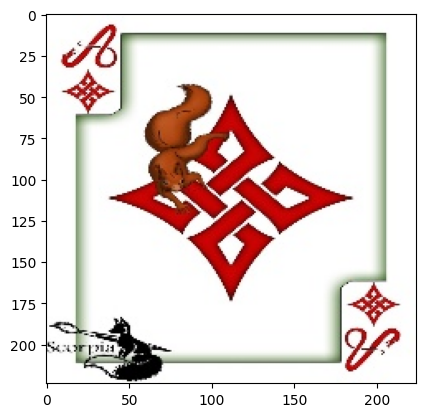

In [3]:
# checking path is working and image found
img = cv2.imread(os.path.join(path, '01_train', 'ace of diamonds', '023.jpg'))
print('Image Shape:', img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #COLOR_BGR2RGB - corrects the color scale of image imported
plt.show()

In [4]:
# Batch size and image size imputs
batch_size = 128
image_width  = 256
image_height = 256

# Set directory paths
data_dir_train = os.path.join(path, '01_train')
data_dir_valid = os.path.join(path, '02_valid')
data_dir_test = os.path.join(path, '03_test')

# Load image datasets
data_train = tf.keras.utils.image_dataset_from_directory(data_dir_train, batch_size=batch_size, image_size=(image_width, image_height))
data_valid = tf.keras.utils.image_dataset_from_directory(data_dir_valid, batch_size=batch_size, image_size=(image_width, image_height))
data_test = tf.keras.utils.image_dataset_from_directory(data_dir_test, batch_size=batch_size, image_size=(image_width, image_height))

# Number of batches per dataset
print('Number of training batches:', len(data_train))
print('Number of validation batches:', len(data_valid))
print('Number of testing batches:', len(data_test))

Found 7631 files belonging to 53 classes.
Found 265 files belonging to 53 classes.
Found 265 files belonging to 53 classes.
Number of training batches: 60
Number of validation batches: 3
Number of testing batches: 3


In [5]:
# Data interators
data_iterator_train = data_train.as_numpy_iterator()
data_iterator_valid = data_valid.as_numpy_iterator()
data_iterator_test = data_test.as_numpy_iterator()

# Create and check shape of data batches from data iterators
batch_train = data_iterator_train.next()
batch_valid = data_iterator_valid.next()
batch_test = data_iterator_test.next()

print('Training batch shape:', batch_train[0].shape)
print('Validation batch shape:', batch_valid[0].shape)
print('Testing batch shape:', batch_test[0].shape)

Training batch shape: (128, 256, 256, 3)
Validation batch shape: (128, 256, 256, 3)
Testing batch shape: (128, 256, 256, 3)


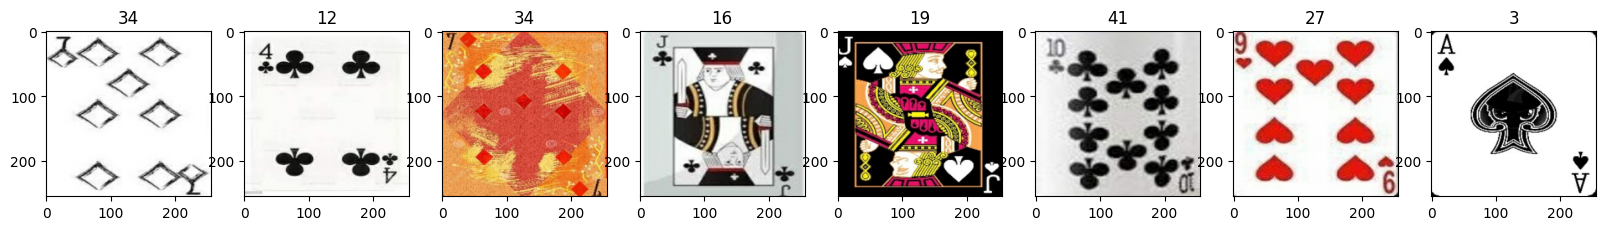

In [6]:
# View a small sample of training dataset
fig, ax = plt.subplots(ncols=8, figsize=(20,20))
for idx, img in enumerate(batch_train[0][:8]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch_train[1][idx])

---

**2. Preprocessing Data**

Effective data preprocessing, including image augmentation techniques such as rotation, shifts, zooming, and flips, is essential for optimizing the Deep-CNN Playing Card Classifier. These methods diversify the training dataset, improve model robustness, and normalize pixel values to enhance consistency. By splitting the dataset into training and validation sets, the classifier is poised to accurately classify playing card suits and ranks, ensuring reliable performance and generalization capabilities.

In [7]:
# import tensorflow specific libraries
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

2.1 Scale Data

In [8]:
# This layer is added into the NN later
normalization_layer = layers.Rescaling(1./255)

# Normalization model to help with the visualisation of image augmentation
data_normalization = keras.Sequential([normalization_layer])

2.2 Augment Data

In [9]:
# Create a image augmentation process to the data pipeline
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.5),
     layers.RandomZoom(0.5),
     layers.RandomContrast(0.5),
     layers.RandomTranslation(height_factor = 0.25, width_factor = 0.25)
     ])

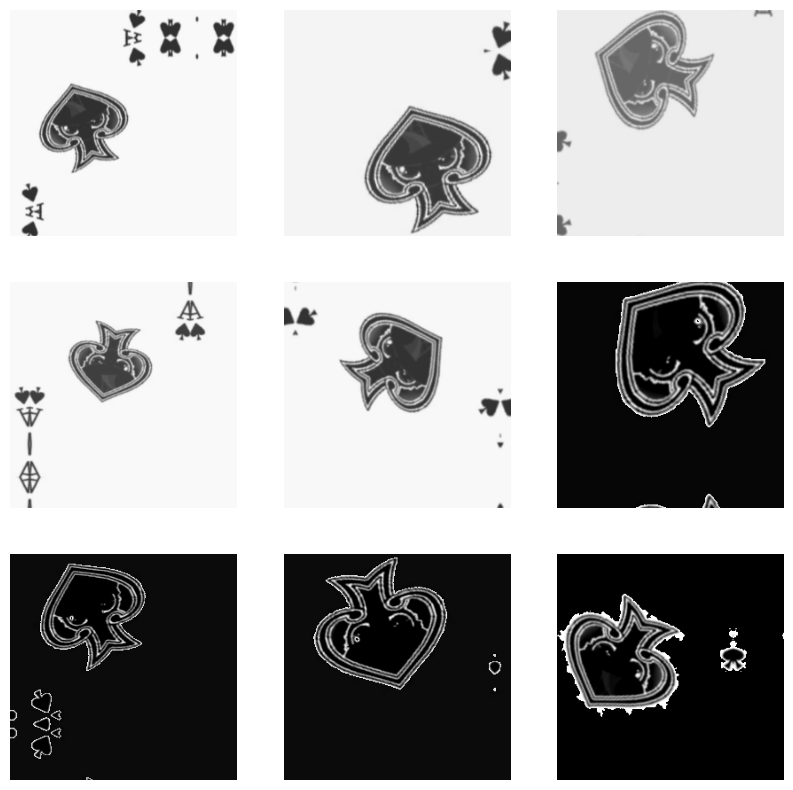

In [10]:
# Create a simgle image batch by expanding dimensions
single_img_batch = tf.expand_dims(img, 0)

# Plot sample of image augmentation
plt.figure(figsize=(10, 10))
for i in range(9):
  normalized_image = data_normalization(single_img_batch)
  augmented_image = data_augmentation(normalized_image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow((augmented_image[0]* 255).numpy().astype('uint8'))
  plt.axis("off")

---

**3. Deep CNN Model**


In this section, we build the architecture of the Deep CNN classifier designed for playing card classification. Following the architecture design, we train and test the model using a curated dataset. Subsequently, we visualize the performance metrics to assess the classifier's accuracy and effectiveness in correctly identifying both the suit and rank of playing cards.

3.1 Build Deep Learning Model

In [11]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import regularizers

In [12]:
model = Sequential([
    data_normalization,
    data_augmentation,
    Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3),),
    MaxPooling2D(),
    Conv2D(32, (3,3), 1, activation='relu'),
    MaxPooling2D(),
    Conv2D(16, (3,3), 1, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu',activity_regularizer=regularizers.L2(0.01)),
    Dropout(0.5),
    Dense(53)]
)

In [13]:
model.compile('adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['sparse_categorical_accuracy'])
#https://stackabuse.com/what-is-fromlogitstrue-in-keras-tensorflow-loss-functions/

In [14]:
input_shape = (batch_size, image_width, image_height, 3)
print('Input Shape:', input_shape)
model.build(input_shape)

Input Shape: (128, 256, 256, 3)


In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (128, 254, 254, 16)       448       
                                                                 
 max_pooling2d (MaxPooling2  (128, 127, 127, 16)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (128, 125, 125, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (128, 62, 62, 32)         0         
 g2D)                                                 

3.2 Training Model

In [16]:
logdir='logs'

In [17]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [18]:
hist = model.fit(data_train, epochs=10, validation_data=data_valid, callbacks=[tensorboard_callback])
model.save_weights('/content/drive/MyDrive/Colab Notebooks/Deep_CNN_Image_Classifier_Playing_Cards/checkpoint2')

Epoch 1/10
60/60 [==============================] - 601s 10s/step - loss: 3.9579 - sparse_categorical_accuracy: 0.0253 - val_loss: 3.9256 - val_sparse_categorical_accuracy: 0.0453
Epoch 2/10
60/60 [==============================] - 596s 10s/step - loss: 3.9157 - sparse_categorical_accuracy: 0.0367 - val_loss: 3.8906 - val_sparse_categorical_accuracy: 0.0340
Epoch 3/10
60/60 [==============================] - 598s 10s/step - loss: 3.8880 - sparse_categorical_accuracy: 0.0368 - val_loss: 3.8108 - val_sparse_categorical_accuracy: 0.0377
Epoch 4/10
60/60 [==============================] - 601s 10s/step - loss: 3.8327 - sparse_categorical_accuracy: 0.0438 - val_loss: 3.7962 - val_sparse_categorical_accuracy: 0.0377
Epoch 5/10
60/60 [==============================] - 586s 10s/step - loss: 3.7919 - sparse_categorical_accuracy: 0.0493 - val_loss: 3.7156 - val_sparse_categorical_accuracy: 0.0226
Epoch 6/10
60/60 [==============================] - 577s 10s/step - loss: 3.7381 - sparse_categorica

In [19]:
model.save_weights('/content/drive/MyDrive/Colab Notebooks/Deep_CNN_Image_Classifier_Playing_Cards/checkpoint2')

3.3 Plot Performance

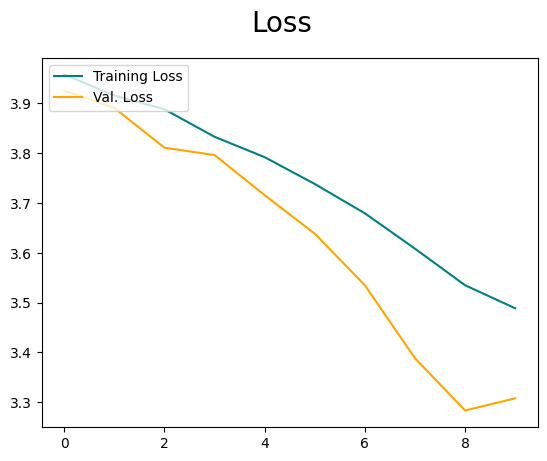

In [20]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'Training Loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'Val. Loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

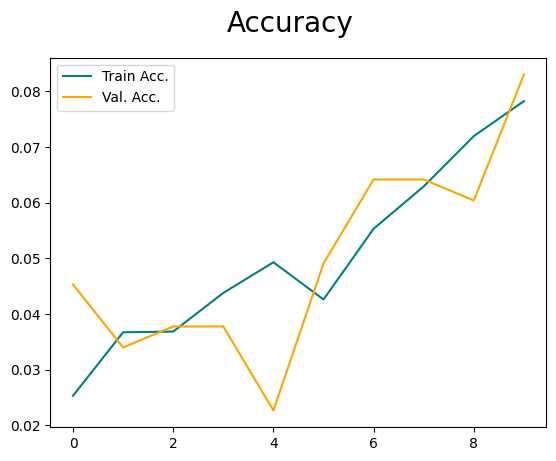

In [21]:
fig = plt.figure()
plt.plot(hist.history['sparse_categorical_accuracy'], color = 'teal', label = 'Train Acc.')
plt.plot(hist.history['val_sparse_categorical_accuracy'], color = 'orange', label = 'Val. Acc.')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

---

**4. Evaluate Performance**

Next, we evaluate the Deep CNN classifier by testing it on unseen data and analyzing the results and graphs from the previous section. Based on this evaluation, we suggest potential improvements to the model to enhance its accuracy in identifying both the suit and rank of playing cards.

4.1 Evaluate

In [22]:
results = model.evaluate(data_test)
print('Model loss on test data:', results[0])
print('Model accuracy on test data:', results[1])

3/3 [==============================] - 6s 2s/step - loss: 3.3457 - sparse_categorical_accuracy: 0.0566
Model loss on test data: 3.345661163330078
Model accuracy on test data: 0.056603774428367615


The graphs show that both the training and testing losses are decreasing, while the accuracy for both is still increasing. This suggests that the model has not been trained for a sufficient number of epochs. The next step is to increase the number of epochs and review the results afterward. However, due to computational limitations, this study will proceed using the current, suboptimal results.

4.2 Test

Despite the suboptimal results, the model will be tested on a single card to assess its ability to accurately predict the type. Given the undertraining in the previous section, we do not expect it to perform well.

In [23]:
#Create category/card type dictionary
card_type = {
  0: "ace of clubs",
  1: "ace of diamonds",
  2: "ace of hearts",
  3: "ace of spades",
  4: "eight of clubs",
  5: "eight of diamonds",
  6: "eight of hearts",
  7: "eight of spades",
  8: "five of clubs",
  9: "five of diamonds",
  10: "five of hearts",
  11: "five of spades",
  12: "four of clubs",
  13: "four of diamonds",
  14: "four of hearts",
  15: "four of spades",
  16: "jack of clubs",
  17: "jack of diamonds",
  18: "jack of hearts",
  19: "jack of spades",
  20: "joker",
  21: "king of clubs",
  22: "king of diamonds",
  23: "king of hearts",
  24: "king of spades",
  25: "nine of clubs",
  26: "nine of diamonds",
  27: "nine of hearts",
  28: "nine of spades",
  29: "queen of clubs",
  30: "queen of diamonds",
  31: "queen of hearts",
  32: "queen of spades",
  33: "seven of clubs",
  34: "seven of diamonds",
  35: "seven of hearts",
  36: "seven of spades",
  37: "six of clubs",
  38: "six of diamonds",
  39: "six of hearts",
  40: "six of spades",
  41: "ten of clubs",
  42: "ten of diamonds",
  43: "ten of hearts",
  44: "ten of spades",
  45: "three of clubs",
  46: "three of diamonds",
  47: "three of hearts",
  48: "three of spades",
  49: "two of clubs",
  50: "two of diamonds",
  51: "two of hearts",
  52: "two of spades"
}

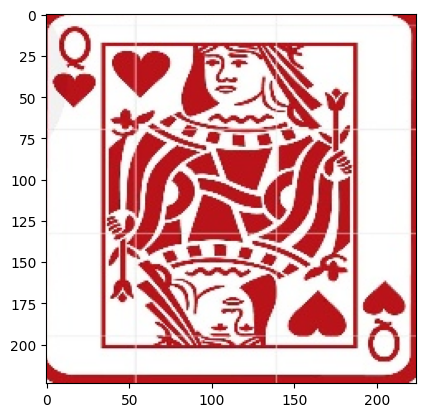

In [24]:
#Load random card
img = cv2.imread(os.path.join(path, '04_random-test-images','Copia-de-001.jpg'))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [25]:
# some preprocessing of the image
image_pred = tf.image.resize(img, (256,256))

# Prediction
predict = model.predict(np.expand_dims(image_pred/255,0))
print('the card is:', card_type.get(np.argmax(predict, axis=1)[0]))

1/1 [==============================] - 0s 240ms/step
the card is: ace of spades


As expected from the model's undertraining, it correctly predicted neither the suit nor the number. This image was part of the training set, so the model was expected to have some familiarity with it.

With the data pipeline and model now functional, it's time to focus on improvements. First, the model should be trained until the losses and/or accuracy no longer show significant changes between epochs. Depending on the outcome of this retraining, further adjustments may be needed in the data processing, model architecture, hyperparameters, and other areas.